# Outline:

1. Basic ingredients of Quantum Jump Monte Carlo(QJMC) method

2. Set up the code for QJMC method

3. Apply the method to two-level system, and compare it with the exact result.

4. Apply the method to interacting atoms, and compare it with the exact result.

# 1. Basics

# Lindblad master equation

$\partial_{t}\rho = -\frac{i}{\hbar}[H,\rho] + \sum \gamma_{i}(L_{i}\rho L_{i}^{\dagger}-\frac{1}{2}\{L_{i}^{\dagger}L_{i},\rho \})$

# Quantum jump Monte Carlo(QJMC)

$H_{eff} = H - H_{d} = H - \frac{i\hbar}{2}\sum \gamma_{i}L_{i}^{\dagger}L_{i}$

$\delta p = \delta t\bra{\phi(t)}\frac{i}{\hbar}(H_{eff}-H^{\dagger}_{eff}) \ket{\phi(t)}= \delta t\bra{\phi(t)}\sum\gamma_{i}L_{i}^{\dagger}L_{i}\ket{\phi(t)}$, or equivalently

If random number r > $\delta p$, evolve the state:

$\ket{\phi(t+\delta t)}= \sqrt{\frac{1}{1-\delta p}}(I-\frac{i}{\hbar}H_{eff}\delta t)\ket{\phi(t)}$

If random number r < $\delta p$, apply jump(with probability $\pi_{i}=\frac{\delta p_{i}}{\delta p}$, choose $L_{i}$)

$\ket{\phi(t+\delta t)}= \sqrt{\gamma_{i}\frac{\delta t}{\delta p_{i}}} L_{i}\ket{\phi(t)}$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.linalg import expm

Define the matrices we need. 

In [6]:
# Basis = {|g), |e)} 
# |g) = [1, 0] , |e) = [0, 1]
g = np.array([1, 0], dtype=complex)
e = np.array([0, 1], dtype=complex)

# Pauli matrices = {id, s_x, s_minus, s_plus}
# id = I = [[(g|I|g), (g|I|e)], [(e|I|g), (e|I|e)]] = [[1, 0], [0, 1]]
# s_x = |e)(g|+|g)(e| = [[(g||e)(g|+|g)(e||g), (g||e)(g|+|g)(e||e)], [(e||e)(g|+|g)(e||g), (e||e)(g|+|g)(e||e)]] = [[0, 1], [1, 0]]
# s_minus = |g)(e| = [[(g||g)(e||g), (g||g)(e||e)], [(e||g)(e||g), (e||g)(e||e)]] = [[0, 1], [0, 0]]
# s_plus = |e)(g| = [[(g||e)(g||g), (g||e)(g||e)], [(e||e)(g||g), (e||e)(g||e)]] = [[0, 0], [1, 0]]
id = np.eye(2, dtype = complex)
s_x = np.array([[0, 1], [1, 0]], dtype=complex)
s_minus = np.array([[0, 1], [0, 0]], dtype=complex)
s_plus =  np.array([[0, 0], [1, 0]], dtype=complex)



In [71]:
# Basis = {gg , ge , eg , ee}
# gg =|g)|g), ge = |g)|e), eg = |e)|g), ee = |e)|e)
gg = np.kron(g,g)
ge = np.kron(g,e)
eg = np.kron(e,g)
ee = np.kron(e,e)

# Basis of density matrices = {GG, GE, EG, EE}
# GG = |g)(g|  , GE = |g)(e| , EG = |e)(g| , EE = |e)(e|
GG = np.outer(g,g)
GE = np.outer(g,e)
EG = np.outer(e,g)
EE = np.outer(e,e)
rho_basis_1 = [GG, GE, EG, EE]

# GGGG = |g)|g).(g|(g| 
# GGGE = |g)|g).(g|(e|
# GGEG = |g)|g).(e|(g| 
# GGEE = |g)|g).(e|(e|
GGGG = np.outer(gg,gg)
GGGE = np.outer(gg,ge)
GGEG = np.outer(gg,eg)
GGEE = np.outer(gg,ee)
# GEGG = |g)|e).(g|(g| 
# GEGE = |g)|e).(g|(e|
# GEEG = |g)|e).(e|(g| 
# GEEE = |g)|e).(e|(e|
GEGG = np.outer(ge,gg)
GEGE = np.outer(ge,ge)
GEEG = np.outer(ge,eg)
GEEE = np.outer(ge,ee)
# EGGG = |e)|g).(g|(g| 
# EGGE = |e)|g).(g|(e|
# EGEG = |e)|g).(e|(g| 
# EGEE = |e)|g).(e|(e|
EGGG = np.outer(eg,gg)
EGGE = np.outer(eg,ge)
EGEG = np.outer(eg,eg)
EGEE = np.outer(eg,ee)
# EEGG = |e)|e).(g|(g| 
# EEGE = |e)|e).(g|(e|
# EEEG = |e)|e).(e|(g| 
# EEEE = |e)|e).(e|(e|
EEGG = np.outer(ee,gg)
EEGE = np.outer(ee,ge)
EEEG = np.outer(ee,eg)
EEEE = np.outer(ee,ee)
rho_basis_2 = [GGGG, GGGE, GGEG, GGEE, GEGG, GEGE, GEEG, GEEE, EGGG, EGGE, EGEG, EGEE, EEGG, EEGE, EEEG, EEEE]
# rho_basis_2 is the list of othonormal basis for 16-dim Hilbert space.


# Lists of one- and two-body operators
# [n-1][m-1] : n-body operators, m-th particle operator
Id = [[id], [np.kron(id, id)]]
S_x = [[s_x], [np.kron(s_x, id), np.kron(id, s_x)]]
S_plus = [[s_plus], [np.kron(s_plus, id), np.kron(id, s_plus)]]
S_minus = [[s_minus], [np.kron(s_minus, id), np.kron(id, s_minus)]]



Define some useful functions

In [72]:
# Input: (2^n x 2^n matrix)
# Output: (2^n x 2^n matrix)
def dagger(matrix):
    return np.conj(matrix).T

# Input: (2^n x 2^n matrix), (2^n x 2^n matrix)
# Output: (2^n x 2^n matrix)
def commutator(op1, op2, sign):
    if sign == 0:
        return op1@op2 - op2@op1
    else:
        return op1@op2 + op2@op1


# Input: (2^n x 2^n matrix), (list of 2^n x 2^n matrix), (list of values)
# Output: (2^n x 2^n matrix), (2^n x 2^n matrix), (2^n x 2^n matrix)
def effective_Hamiltonian(H, L_ops, gamma_values):
    
    # Check the system size
    n = len(gamma_values)
    
    # Dissipator
    H_d = np.zeros((2 ** n, 2 ** n), dtype = complex)
    for gamma, L in zip(gamma_values, L_ops):
        H_d += 1j/2 * gamma * dagger(L) @ L
             
    # Non-Hermitian Hamiltonian
    H_eff = H -  H_d
    H_eff_dagger = dagger(H_eff)
    
    return H_eff, H_eff_dagger, H_d
    
# Input: (2^n x 1 arrays), (2^n x 2^n matrix)
# Output: (2^n x 1 arrays)
def jump(state, gamma, L):
    state = gamma * (L @ state) 
    state = state / np.sqrt((dagger(state)@state))  # Keep normalized
    return state

# Input: (2^n x 1 arrays), (2^n x 2^n matrix), (2^n x 2^n matrix), value
# Output: (2^n x 1 arrays)
def propagate(state, id, H_eff, dt):
    state =  (id - 1j * H_eff * dt) @ state
    state = state / np.sqrt((dagger(state)@state))  # Keep normalized
    return state



Then, build a function which calculate $\delta p = \sum \delta p_{i}$ and pick a $L_{i}$ according to the relative probability $\pi_{i} = \frac{\delta p_{i}}{\delta p}$.

In [73]:
# Input: 
# quantum states(2^n x 2^n matrix), jump operators L(list of 2^n x 2^n matrix),
# decay rate(list of values), dt(value)
# Output: 
# jump probability(value), chosen_gamma(value), 
# chosen L(2^n x 2^n matrix), chosen_dp(value)
def quantum_jump_probabilities(state, L_ops, gamma_values, dt):
    dp_values = []
    
    for L, gamma in zip(L_ops, gamma_values):
        
        # Compute dp_i = dt * gamma_i *  <state| L^{+}_i * L_i |state> 
        dp = dt * gamma * (dagger(state)@  dagger(L) @ L @ state)
        dp = np.real(dp)
        dp_values.append(dp)
        
    # calculate dp and normalized dp_i
    dp_total = np.sum(dp_values)
    if dp_total != 0:
        normalized_dp_values = [x / dp_total for x in dp_values]
        # Pick gamma_i and L_i
        chosen_index = np.random.choice(len(L_ops), p=normalized_dp_values)
        chosen_gamma = gamma_values[chosen_index]
        chosen_L = L_ops[chosen_index]
        chosen_dp = dp_values[chosen_index]
    else:
        normalized_dp_values = chosen_gamma = chosen_L = chosen_dp = chosen_index = None  
      

    return dp_total, chosen_gamma, chosen_L, chosen_dp, chosen_index

# --------------------------Test case --------------------------
state = g
L_ops = [S_minus[0][0]]  
gamma_values = [5]  
dt = 0.001  

for i in range(1):
    dp_data = quantum_jump_probabilities(state, L_ops, gamma_values, dt)

    print("Total Jump Probability, chosen_gamma, chosen_L, chosen_dp, chosen_index are: ", dp_data[0], dp_data[1], dp_data[2], dp_data[3], dp_data[4])



state = gg
L_ops = [S_minus[1][0], S_minus[1][1]]  
gamma_values = [5,8]  
dt = 0.001  

for i in range(1):
    dp_data = quantum_jump_probabilities(state, L_ops, gamma_values, dt)

    print("Total Jump Probability, chosen_gamma, chosen_L, chosen_dp, chosen_index are: ", dp_data[0], dp_data[1], dp_data[2], dp_data[3], dp_data[4])

# --------------------------End of test case --------------------------


Total Jump Probability, chosen_gamma, chosen_L, chosen_dp, chosen_index are:  0.0 None None None None
Total Jump Probability, chosen_gamma, chosen_L, chosen_dp, chosen_index are:  0.0 None None None None


Then, build a function to simulate trajectories of n particles(or n modes).

In [139]:
# Input : 
# initial state(2^n x 1 array), Hamiltonian(2^n x 2^n matrix),
# jump operators(list of 2^n x 2^n matrices), decay rate(list of values), 
# total_time(value), dt(value)

# Output : 
# [0] : time-evolved states(list of 2^n x 2^n matrix)
# [1][i-1] : time-evolved excitation density of i-th particle(list of values)
def single_simulation(state, H, L_ops, gamma_values, total_time, dt):
    
    # Check the system size
    n = len(gamma_values)
    
    # Storage for the quantum states for all time 
    state_vecs = [] 
    
    # Storage for each particle's excitation densities for all time  
    n_e_values = [[] for _ in range(n)]
    
    # Storage for time
    time_values = []
    
    # Set up initial condition phi(t=0) 
    current_time = 0
    current_state = state
    
    # Some auxiliary data: counting jumps, etc...
    jump_num = 0
    index_num = [0, 0]
    
    # Set-up non-Hermitian Hamiltonian
    H_eff, H_eff_dagger, H_d = effective_Hamiltonian(H, L_ops, gamma_values)
    
    # Start the trajectory simulation
    while current_time < total_time:
        
        # Record current quantum state and time
        state_vecs.append(current_state)
        time_values.append(current_time)
        
        # Record current excitation density of each particle
        # ne(ith particle) = |phi[last term]|^2 + |phi[other terms that contain ith-particle's excited state]|^2    
        for i in range(n):  # for ith particle
            n_e = np.abs(current_state[2**n - 1])**2
            if n > 1: n_e += np.abs(current_state[2**n - 2 - i])**2
            n_e_values[i].append(n_e)

        # Calculate jump probability, pick a L_i along with gamma_i and dp_i 
        dp_data = quantum_jump_probabilities(current_state, L_ops, gamma_values, dt)
        dp_total = dp_data[0]
        chosen_gamma = dp_data[1]
        chosen_L = dp_data[2]
        chosen_dp = dp_data[3]
        chosen_index = dp_data[4]

        
        # Check jump condition
        jump_occurs = np.random.rand() < dp_total
        
        # Propagate the state 
        if jump_occurs:
            current_state = jump(current_state, chosen_gamma, chosen_L)
            jump_num += 1
            if chosen_index == 0: index_num[0] +=1
            else: index_num[1] +=1
        else:
            current_state = propagate(current_state, Id[n-1][0], H_eff, dt)

        # update time
        current_time += dt


    return state_vecs, n_e_values, time_values, jump_num, index_num


# Output:
# [0][m-1] : time-evolved states in m-th trajectory (list of 2^n x 1 arrays)
# [1][m-1][i-1] : time-evolved excitation density of i-th particle in m-th trajectory (list of values)
def multiple_simulations(N, state, H, L_ops, gamma_values, total_time, dt):

    # Storage for data from each single simulation
    state_vecs = []
    n_e_values = []
    jump_num_values = []
    index_num_values = []

    for _ in range(N):
        
        single_simulation_result = single_simulation(state, H, L_ops, gamma_values, total_time, dt)
 
        state_vecs.append(single_simulation_result[0])
        n_e_values.append(single_simulation_result[1])
        jump_num_values.append(single_simulation_result[3])
        index_num_values.append(single_simulation_result[4])

    time_values = single_simulation_result[2]

    return state_vecs, n_e_values, time_values, jump_num_values, index_num_values

    

# 3. Two level system

Master equation: 

$\partial_{t}\rho = -i\Omega[\sigma^{x},\rho] + \gamma(\sigma^{-}\rho\sigma^{+}- \frac{1}{2}\{\sigma^{+}\sigma^{-},\rho\})$

This is the Lindbladian form with

$H = \Omega\sigma^{x}$

$L^{\dagger}_i = L^{\dagger} = \sigma^{+} \hspace{1em}$, $\hspace{1em}L_i = L = \sigma^{-}$

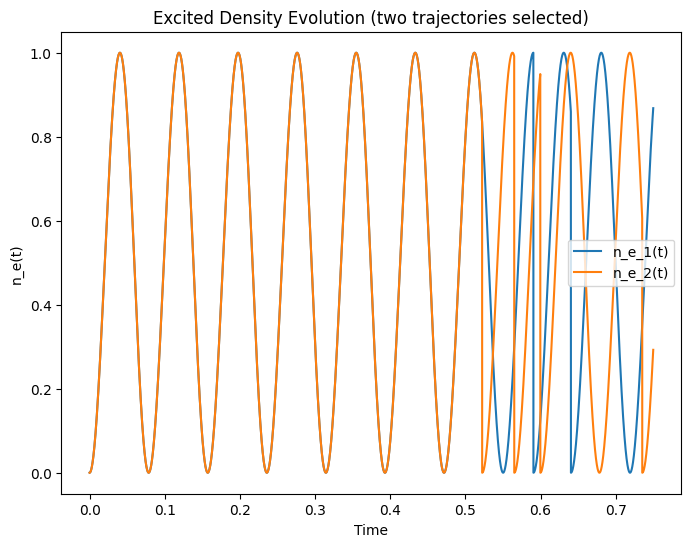

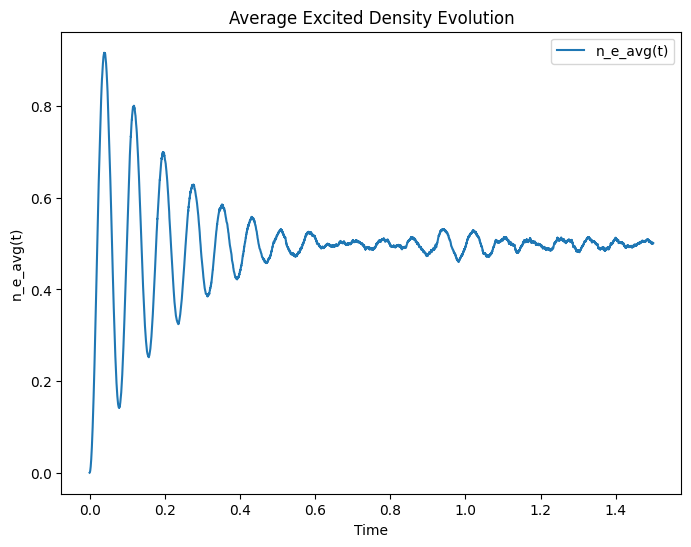

In [146]:
# Define Hamiltonian, jump operators of the two level system (let hbar=1)
omega = 40
H = omega * S_x[0][0]
L_ops = [S_minus[0][0]]
gamma_values = [40/6]

# Set up initial state and time parameters
phi = g
total_time = 1.5
dt = 0.0001

# Start N-trajectory simulation
N = 1000
state_vecs, n_e_values, time_values, jump_num_values, index_num_values = multiple_simulations(N, phi, H, L_ops, gamma_values, total_time, dt)

# Reminder for the outcome data: 
# state_vecs = [ [phi(t)]_1, [phi(t)]_2, ...., [phi(t)]_N ]
# n_e_values = [ [{n_e(t)}]_1, [{n_e(t)}]_2, ...., [{n_e(t)}]_N ]
# time_values = [t1, t2,....., t_total]

# Calculate the trajectory-averaged excitation density
n_e_array = []
sum_values = np.zeros(np.shape(n_e_values[0][0]),dtype = complex)
for i in range(N):
    n_e_array.append(np.array(n_e_values[i][0]))
    sum_values += n_e_values[i][0]
    
n_e_avg_array = np.array(sum_values / N)

# Plot the results
plt.figure(figsize=(8,6))

for i in range(2):
    plt.plot(time_values[:len(time_values)//2], n_e_array[i][:len(n_e_array[i])//2], label=f'n_e_{i + 1}(t)')
    
plt.title('Excited Density Evolution (two trajectories selected)')
plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
plt.plot(time_values, n_e_avg_array, label='n_e_avg(t)')
plt.title('Average Excited Density Evolution')
plt.xlabel('Time')
plt.ylabel('n_e_avg(t)')
plt.legend()
plt.show()

# Compared to the exact result

(1) Exactly solve the eigenvalues and eigenvectors of the superoperator 

$L[\rho]=-i[\Omega\sigma^{x},\rho] + \gamma(\sigma^{-}\rho\sigma^{+}- \frac{1}{2}(\sigma^{+}\sigma^{-}\rho+\rho\sigma^{+}\sigma^{-}))$ 

whose matrix representation is 

$
\begin{pmatrix}
    0 & i\Omega & -i\Omega & \gamma\\
    i\Omega & -\frac{\gamma}{2} & 0 & -i\Omega\\
    -i\Omega & 0 & -\frac{\gamma}{2} & i\Omega\\
    0 & -i\Omega & i\Omega & -\gamma\\
\end{pmatrix}
\begin{pmatrix}
    \rho_{gg} \\
    \rho_{ge} \\
    \rho_{eg} \\
    \rho_{ee} \\
\end{pmatrix} = \lambda 
\begin{pmatrix}
    \rho_{gg} \\
    \rho_{ge} \\
    \rho_{eg} \\
    \rho_{ee} \\
\end{pmatrix}
$

$\rho(t) = \sum c_{i} e^{\lambda_{i}t} u_{i} \hspace{2em}$ where $\hspace{2em} c_{i} =u^{\dagger}_{i}\rho(0)\hspace{2em}$ 

$\lambda_{1} = 0 \;, \hspace{13em}
\mathbf{u_{1}} = \begin{pmatrix}
    1+\frac{\gamma^{2}}{4\Omega^{2}} \\
    \frac{i\gamma}{2\Omega} \\
    -\frac{i\gamma}{2\Omega} \\
    1 \\
\end{pmatrix}
 $

$\lambda_{2} = -\frac{\gamma}{2} \;,\hspace{13em} 
\mathbf{u_{2}} = \begin{pmatrix}
    0 \\
    1 \\
    1 \\
    0 \\
\end{pmatrix}
 $

$\lambda_{3} = \frac{1}{4}(-3 \gamma-\sqrt{\gamma^{2}-64\Omega^{2}}) \;, \hspace{4em} 
\mathbf{u_{3}} = \begin{pmatrix}
    -1 \\
    \frac{i8\Omega}{\gamma+\sqrt{\gamma^{2}-64\Omega^{2}}} \\
    -\frac{i8\Omega}{\gamma+\sqrt{\gamma^{2}-64\Omega^{2}}}\\
    1 \\
\end{pmatrix}
 $

$\lambda_{4} = \frac{1}{4}(-3 \gamma+\sqrt{\gamma^{2}-64\Omega^{2}}) \;, \hspace{4em} 
\mathbf{u_{4}} = \begin{pmatrix}
    -1 \\
    -\frac{i8\Omega}{-\gamma+\sqrt{\gamma^{2}-64\Omega^{2}}} \\
    \frac{i8\Omega}{-\gamma+\sqrt{\gamma^{2}-64\Omega^{2}}}\\
    1 \\
\end{pmatrix}
 $

(2) Stationary state $\rho_{ss}$ :

Since $\lambda_{1} = 0$, the stationary state $\rho_{ss}$ is established by $u_{1}$, which is

$\rho_{ss} = \frac{1}{2+\frac{\gamma^{2}}{4\Omega^{2}}}\begin{pmatrix}
    1+\frac{\gamma^{2}}{4\Omega^{2}} & \frac{i\gamma}{2\Omega} \\
    -\frac{i\gamma}{2\Omega} & 1\\
\end{pmatrix}
$

Thus, $n_{e}(t = \infty)= tr(\ket{e}\bra{e}\rho_{ss}) = tr(
\begin{pmatrix}
    0 & 0 \\
    0 & 1 \\ 
\end{pmatrix}
\rho_{ss}) = \frac{1}{2+\frac{\gamma^{2}}{4\Omega^{2}}}$

In [32]:
# Define the value excitation density of the stationary state
gamma = omega / 6
ne_infty = 1/ (2+gamma**2/(4*omega**2))

(3) Full solution $\rho(t)= \sum c_{i} e^{\lambda_{i}t} u_{i} \hspace{2em}$ :

With our chosen initial state

$\hspace{1em}  \mathbf{\rho(t=0)} = \begin{pmatrix}
    1  \\
    0  \\
    0  \\
    0  \\
\end{pmatrix}\hspace{1em}$

c's are determined by the linear equation

$u^{\dagger}_{j}\rho(0)=\sum c_{i}u^{\dagger}_{j}u_{i}$ 

or more explicitly

$
\begin{pmatrix}
    u^{\dagger}_{1}\rho(0) \\
    u^{\dagger}_{2}\rho(0) \\
    u^{\dagger}_{3}\rho(0) \\
    u^{\dagger}_{4}\rho(0) \\
\end{pmatrix} =
\begin{pmatrix}
    u^{\dagger}_{1}u_{1} & u^{\dagger}_{1}u_{2} & u^{\dagger}_{1}u_{3} & u^{\dagger}_{1}u_{4}\\
    u^{\dagger}_{2}u_{1} & u^{\dagger}_{2}u_{2} & u^{\dagger}_{2}u_{3} & u^{\dagger}_{2}u_{4}\\
    u^{\dagger}_{3}u_{1} & u^{\dagger}_{3}u_{2} & u^{\dagger}_{3}u_{3} & u^{\dagger}_{3}u_{4}\\
    u^{\dagger}_{4}u_{1} & u^{\dagger}_{4}u_{2} & u^{\dagger}_{4}u_{3} & u^{\dagger}_{4}u_{4}\\
\end{pmatrix}
\begin{pmatrix}
    c_{1} \\
    c_{2} \\
    c_{3} \\
    c_{4} \\
\end{pmatrix} 
$

solving the c's, along with eigenvalues and eigenvectors, we can establish $\rho(t)$ and make its plot

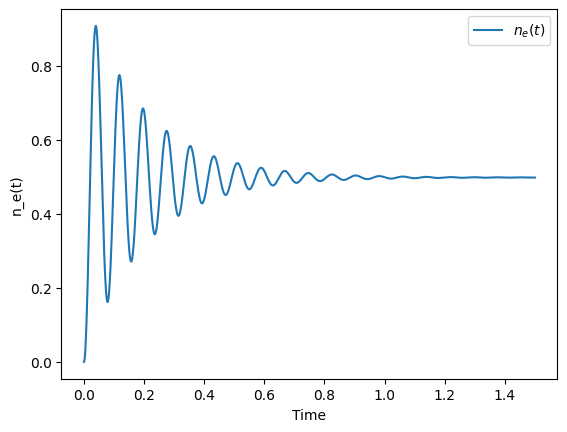

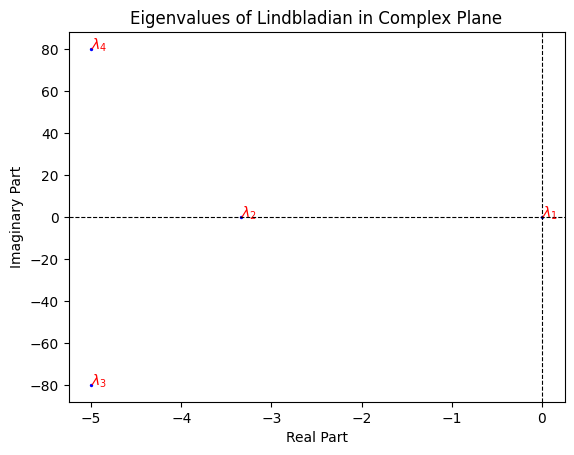

In [147]:
# Initial state
u0 = np.array([1, 0, 0, 0], dtype=complex)

# Define the eigenvectors we've solved
u1 = np.array([1+gamma**2/(4*omega**2), 1j*gamma/(2*omega), -1j*gamma/(2*omega), 1], dtype=complex)
u2 = np.array([0, 1, 1, 0], dtype=complex)
u3 = np.array([-1, 1j*8*omega/(gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), -1j*8*omega/(gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), 1], dtype=complex)
u4 = np.array([-1, -1j*8*omega/(-gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), 1j*8*omega/(-gamma+np.sqrt(gamma**2-64*omega**2,dtype=complex)), 1], dtype=complex)
u = [u1, u2, u3, u4]

# Define the eigenvalues we've solved
l1 = 0
l2 = -gamma/2
l3 = 1/4 * (-3*gamma - np.sqrt(gamma**2 - 64*omega**2, dtype=complex))
l4 = 1/4 * (-3*gamma + np.sqrt(gamma**2 - 64*omega**2, dtype=complex))
l = [l1, l2, l3, l4]

# Solve c1, c2, c3, c4 by Uc = d
U = np.zeros((4,4), dtype=complex)
d = np.zeros((4), dtype=complex)
for m in range(4):
    d[m] = dagger(u[m]) @ u0
    for n in range(4):
        U[m][n] = dagger(u[m]) @ u[n]

c = np.linalg.solve(U,d)

parameters = [c[0], c[1], c[2], c[3], l1, l2, l3, l4, u1, u2, u3, u4]

# Construct the solution rho(t) of the master equation
def Rho(parameters, t):
    state = np.array([0, 0, 0, 0], dtype=complex)
    for i in range(4):
        state += parameters[i] * np.exp(parameters[i+4]*t) * parameters[i+8] 
    return state


t_values = np.linspace(0, 1.5, 15000)

# Construct the excitation density ne(t)
ne = []
ne_infty_values = []
for t in t_values:
    norm = Rho(parameters, t)[0] + Rho(parameters, t)[3]
    ne.append(Rho(parameters, t)[3]/norm)
    ne_infty_values.append(ne_infty)

# Plot
n_e_values = np.array(ne)
plt.plot(t_values, n_e_values, label=r'$n_e(t)$')
plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()

# Plot the eigenvalues on complex plane.
real_parts = np.real(l)
imag_parts = np.imag(l)
plt.scatter(real_parts, imag_parts, color='blue', s=2)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Eigenvalues of Lindbladian in Complex Plane')

for i, txt in enumerate(l):
    plt.annotate(f'$\lambda_{i+1}$', (real_parts[i], imag_parts[i]), color='red')

# plot imaginary part axis
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
# plot real part axis
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.show()



Finally, we put the QJMC and exact result together in the same plot.

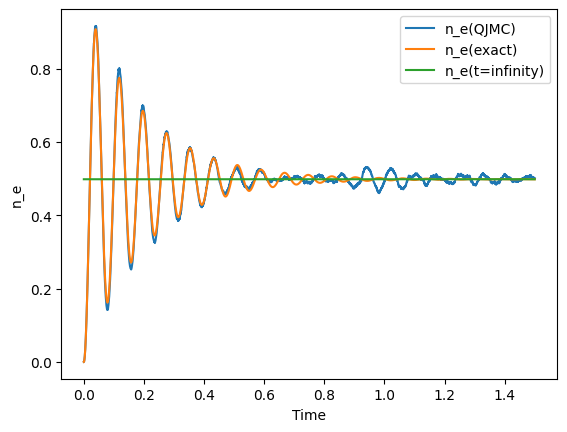

In [148]:
min_length = min(len(time_values), len(n_e_avg_array), len(t_values), len(n_e_values))
n_e_QJMC_aligned = n_e_avg_array[:min_length]
n_e_exact_aligned = n_e_values[:min_length]
time_array_aligned = t_values[:min_length]

plt.plot(time_array_aligned, n_e_QJMC_aligned, label='n_e(QJMC)')
plt.plot(time_array_aligned, n_e_exact_aligned, label='n_e(exact)')
plt.plot(time_array_aligned, ne_infty_values, label='n_e(t=infinity)')

plt.xlabel('Time')
plt.ylabel('n_e')
plt.legend()
plt.show()

# 4. Interacting-atom system

Master equation: 

$\partial_{t}\rho = -i\Omega\sum[\sigma^{x}_{k},\rho] + \gamma\sum(\sigma^{-}_{k}\rho\sigma^{+}_{m}- \frac{1}{2}\{\sigma^{+}_{k}\sigma^{-}_{m},\rho\})$

by diagonalizing $\begin{pmatrix}
    \gamma & \gamma \\
    \gamma & \gamma \\
\end{pmatrix}$, the equation can be transformed into the canonical form 

$\partial_{t}\rho = -\frac{i}{\hbar}[H,\rho] + \sum \gamma_{i}(L_{i}\rho L_{i}^{\dagger}-\frac{1}{2}\{L_{i}^{\dagger}L_{i},\rho \})$

where

$H = \Omega\sum\sigma^{x}_{k}$

$\gamma_{1} = 0 \hspace{2em}, \hspace{1em} L_{1} = \frac{1}{\sqrt{2}}\sigma^{-}_{1}-\frac{1}{\sqrt{2}}\sigma^{-}_{2}$  

$\gamma_{2} = 2\gamma \hspace{1em}, \hspace{1em} L_{2} = \frac{1}{\sqrt{2}}\sigma^{-}_{1}+\frac{1}{\sqrt{2}}\sigma^{-}_{2}$

thus, $\hspace{1em} H_{eff} = H - \frac{i\hbar}{2}\sum \gamma_{i}L_{i}^{\dagger}L_{i}$

Work in the basis $\{E_{1}= \ket{00}, E_{2}= \ket{01}, E_{3}= \ket{10}, E_{4}= \ket{11}\}$, and apply QJMC 

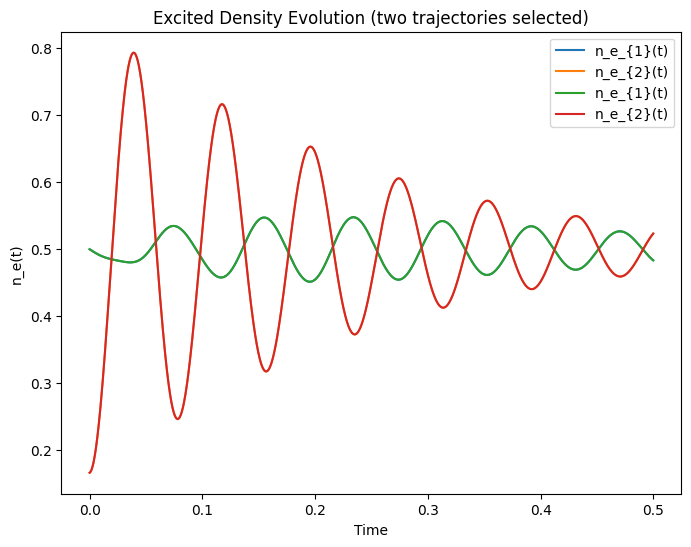

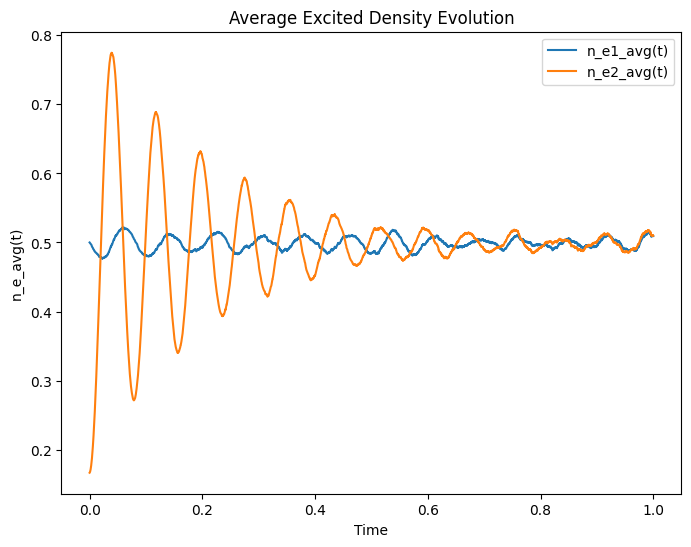

In [149]:
# Define Hamiltonian
H = omega * (S_x[1][0] + S_x[1][1])

# Define jump operators and decay rates : L_ops = [L1, L2], gammas = [0, 2*gamma]
L_1 = np.sqrt(1/2) * (S_minus[1][0] - S_minus[1][1])
L_2 = np.sqrt(1/2) * (S_minus[1][0] + S_minus[1][1])
L_ops = [L_1, L_2]
gamma_values = [0, 2*gamma]

# Set up initial state and time parameters
phi = np.array([np.sqrt(1/3), -np.sqrt(1/6), np.sqrt(1/2), 0], dtype=complex)
total_time = 1.0
dt = 0.0002

# Start N-trajectory simulation
N = 800
state_vecs, n_e_values, time_values, jump_num_values, index_num_values = multiple_simulations(N, phi, H, L_ops, gamma_values, total_time, dt)

# Reminder for the outcome data: 
# state_vecs = [ {phi(t)}_1, {phi(t)}_2, ...., {phi(t)}_N ]
# n_e_values = [ [{n_e1(t)},{n_e2(t)}]_1, [{n_e1(t)},{n_e2(t)}]_2, ...., [{n_e1(t)},{n_e2(t)}]_N ]
# time_values = [t1, t2,....., t_total]


# Calculate the trajectory-averaged excitation density for particle 1 and 2
n_e_1_array = []
n_e_2_array = []
sum_values_1 = np.zeros(np.shape(n_e_values[0][0]),dtype = complex)
sum_values_2 = np.zeros(np.shape(n_e_values[0][0]),dtype = complex)
for i in range(N):
    n_e_1_array.append(np.array(n_e_values[i][0]))
    n_e_2_array.append(np.array(n_e_values[i][1]))
    sum_values_1 += np.array(n_e_values[i][0])
    sum_values_2 += np.array(n_e_values[i][1])
    
n_e_1_avg_array = sum_values_1 / N
n_e_2_avg_array = sum_values_2 / N


# Plot the results
plt.figure(figsize=(8,6))

for i in range(2):
    plt.plot(time_values[:len(time_values)//2], n_e_1_array[i][:len(n_e_1_array[i])//2], label='n_e_{1}(t)')
    plt.plot(time_values[:len(time_values)//2], n_e_2_array[i][:len(n_e_2_array[i])//2], label='n_e_{2}(t)')
    
plt.title('Excited Density Evolution (two trajectories selected)')
plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
plt.plot(time_values, n_e_1_avg_array, label='n_e1_avg(t)')
plt.plot(time_values, n_e_2_avg_array, label='n_e2_avg(t)')
plt.title('Average Excited Density Evolution')
plt.xlabel('Time')
plt.ylabel('n_e_avg(t)')
plt.legend()
plt.show()



# Compared to the exact result

$\partial_{t}\rho = -i[\Omega\sum\sigma^{x}_{k},\rho] + \gamma\sum(\sigma^{-}_{k}\rho\sigma^{+}_{m}- \frac{1}{2}\{\sigma^{+}_{k}\sigma^{-}_{m},\rho\})$

(3.32753624944821-3.785166624581393e-15j)


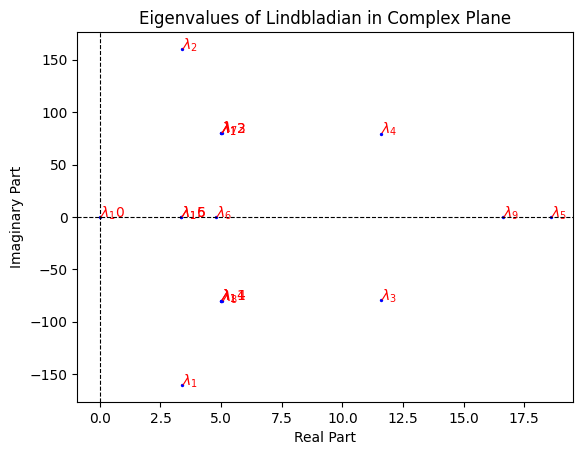

In [46]:
H_atom = omega * (S_x[1][0] + S_x[1][1])
gamma = omega/6
gamma_2 = 2 * gamma

# Matrix representation of the Lindbladian
def Lindblad(rho):
    l0 = -1j * commutator(H_atom, rho, 0)
    l1 = gamma_2*1/2*((S_minus[1][0]+S_minus[1][1]) @ rho @ (S_plus[1][0]+S_plus[1][1]))
    l2 = gamma_2/2 * 1/2 * commutator((S_plus[1][0] + S_plus[1][1]) @ (S_minus[1][0] + S_minus[1][1]), rho, 1)
    return l0+l1+l2

L_matrix = np.zeros((16,16),dtype=complex)
for m in range(16):
    for n in range(16):
        L_matrix[m][n] = np.trace(dagger(rho_basis_2[m]) @ Lindblad(rho_basis_2[n]))
        
# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(L_matrix)

print(eigenvalues[15])


# Plot the eigenvalues on complex plane.
real_parts = np.real(eigenvalues)
imag_parts = np.imag(eigenvalues)
plt.scatter(real_parts, imag_parts, color='blue', s=2)
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.title('Eigenvalues of Lindbladian in Complex Plane')

for i, txt in enumerate(eigenvalues):
    plt.annotate(f'$\lambda_{i+1}$', (real_parts[i], imag_parts[i]), color='red')

# plot imaginary part axis
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)
# plot real part axis
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.show()

We can see that eigenvalues $\lambda_{10} = 0$ 

Correspondingly, stationary state $\rho_{ss} = \rho_{10}$ is formed by the eigenvector $v_{10}$ 

(2) For each stationary state, we obtain $n_{e,k}(\infty)= tr[\hspace{0.5em}\ket{e}\bra{e}_{k}\rho_{ss} \hspace{0.5em}]$ by

$ n_{e,1}(\infty)=tr[\hspace{0.5em}\ket{e}\bra{e}_{1}\rho_{ss}\hspace{0.5em}] = tr[\hspace{0.5em}
\begin{pmatrix}
    0 & 0 \\
    0 & 1 \\ 
\end{pmatrix} \otimes
\begin{pmatrix}
    1 & 0 \\
    0 & 1 \\ 
\end{pmatrix}
\rho_{10}\hspace{0.5em}]
$

$ n_{e,2}(\infty)=tr[\hspace{0.5em}\ket{e}\bra{e}_{2}\rho_{ss}\hspace{0.5em}] = tr[\hspace{0.5em}
\begin{pmatrix}
    1 & 0 \\
    0 & 1 \\ 
\end{pmatrix}  \otimes
\begin{pmatrix}
    0 & 0 \\
    0 & 1 \\ 
\end{pmatrix}
\rho_{10}\hspace{0.5em}]
$

In [47]:
# Define |e)(e|_k with decoherence
excite_1 = np.kron(rho_e[0][0], Id[0][0])
excite_2 = np.kron(Id[0][0], rho_e[0][0])
# Define |e)(e|_k without decoherence
excite_1_mix = np.kron(rho_e[0][0], Id[0][0])
excite_2_mix = np.kron(Id[0][0], rho_e[0][0])

norm = eigenvectors[9][0]+eigenvectors[9][5] + eigenvectors[9][10]+eigenvectors[9][15]
n_e_1_infty = (eigenvectors[9][10]+eigenvectors[9][15])/norm
n_e_2_infty = (eigenvectors[9][5]+eigenvectors[9][15])/norm

print(n_e_1_infty)
print(n_e_2_infty)


(0.7987385066698596-0.0987732844817489j)
(-0.22209248989793356+0.07790806263024358j)


(3) Full solution $\rho(t)= \sum c_{i} e^{\lambda_{i}t} u_{i} \hspace{2em}$ :

With our chosen initial state

$\hspace{1em}  \mathbf{\rho(t=0)} = \begin{pmatrix}
    1  \\
    0  \\
    0  \\
    0  \\
    0  \\
    0  \\
    0  \\
    0  \\
    0  \\
    0  \\
    0  \\
    0  \\
    0  \\
    0  \\
    0  \\
    0  \\
\end{pmatrix}\hspace{1em}$

c's are determined by the linear equation

$u^{\dagger}_{j}\rho(0)=\sum c_{i}u^{\dagger}_{j}u_{i}$ 

In [48]:
# Solve c1, c2, ..., c16 by Uc = d
u0 = np.zeros((16), dtype=complex)
u0[0] = 1
U = np.zeros((16,16), dtype=complex)
d = np.zeros((16), dtype=complex)
for m in range(16):
    d[m] = dagger(eigenvectors[m]) @ u0
    for n in range(16):
        U[m][n] = dagger(eigenvectors[m]) @ eigenvectors[n]

c = np.linalg.solve(U,d)

# Construct the solution rho(t) of the master equation
parameters = []
parameters.append(c)
parameters.append(eigenvalues)
parameters.append(eigenvectors)

def Rho(parameters, t):
    state = np.zeros((16), dtype=complex)
    for i in range(16):
        state += parameters[0][i] * np.exp(parameters[1][i]*t) * parameters[2][i] 
    return state

t_values = np.linspace(0, 5, 20000)


# Construct the excitation density n_e_1(t), n_e_2(t)
# n_e_1 = tr(|1)(1|_1 . rho) = tr(E3E3.rho) + tr(E4E4.rho) = rho[10] + rho[15]
# n_e_2 = tr(|1)(1|_2 . rho) = tr(E2E2.rho) + tr(E4E4.rho) = rho[5] + rho[15]
n_e_1 = []
n_e_2 = []
n_e_1_infty_values = []
n_e_2_infty_values = []

for t in t_values:
    norm = Rho(parameters, t)[0] + Rho(parameters, t)[5] + Rho(parameters, t)[10] + Rho(parameters, t)[15]
    n_e_1.append( (Rho(parameters, t)[10] + Rho(parameters, t)[15]) / norm )
    n_e_2.append( (Rho(parameters, t)[5] + Rho(parameters, t)[15]) / norm )
    n_e_1_infty_values.append(n_e_1_infty)
    n_e_2_infty_values.append(n_e_2_infty)
    





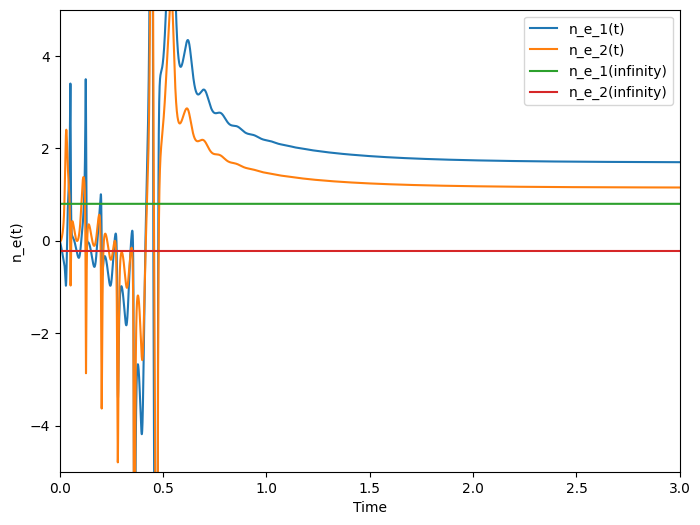

In [144]:
# Plot
plt.figure(figsize=(8,6))
n_e_1_values = np.array(n_e_1)
n_e_2_values = np.array(n_e_2)
plt.plot(t_values, n_e_1, label='n_e_1(t)')
plt.plot(t_values, n_e_2, label='n_e_2(t)')
plt.plot(t_values, n_e_1_infty_values, label='n_e_1(infinity)')
plt.plot(t_values, n_e_2_infty_values, label='n_e_2(infinity)')

plt.xlim(0, 3)
plt.ylim(-5, 5)
plt.xlabel('Time')
plt.ylabel('n_e(t)')
plt.legend()
plt.show()
